#Project Dissertation (CI7000_A_SPAN1_21)

## Content_Based Methods


---


*    Ladan Saeidi - K2145352


# Making Recommendation System using Content Based Methods

In [1]:
# Import libraries and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Read data
ratings = pd.read_csv('ratings.csv', encoding='latin-1', usecols=['userId', 'movieId', 'rating'])
movies = pd.read_csv('movies.csv', encoding='latin-1', usecols=['movieId', 'title', 'genres'])

In [3]:
# Dateset has 100,836 Rows and 3 Columns
# we deleted timestamp beasue it has not been used in our recommendation system
ratings.shape

(100836, 3)

In [4]:
# Look at the 5 rows of users dataset by chance
ratings.sample(5)

,userId,movieId,rating
48773,316,3258,3.5
66063,425,2657,3.0
85007,552,2470,3.5
17417,111,4886,3.0
90082,586,1374,5.0


In [5]:
# Look at the 5 rows of movies dataset by chance
movies.sample(5)

,movieId,title,genres
2673,3577,Two Moon Junction (1988),Drama|Romance
1566,2104,Tex (1982),Drama
7444,81191,Waiting for 'Superman' (2010),Documentary
3976,5609,Ballistic: Ecks vs. Sever (2002),Action|Thriller
6841,61401,"Spirit, The (2008)",Action|Comedy|Fantasy|Thriller


# Plotting the Contribution of Ratings

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


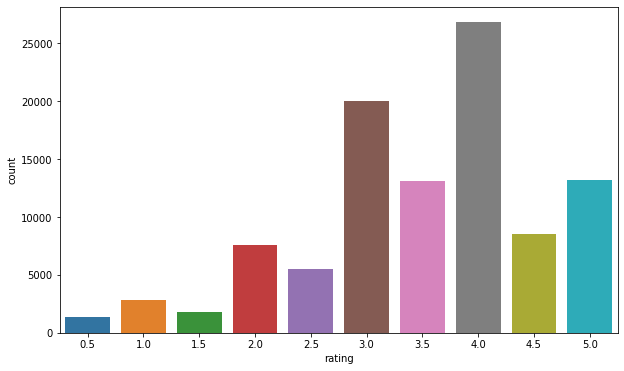

In [6]:
# Plotting the contribution of ratings
plt.figure(figsize=(10,6))
sns.countplot(ratings['rating'].fillna(ratings['rating'].median()))

Which are the most popular movies?

We can take a weighted score taking into account both the ratings and the amount of views to answer this question:

In [ ]:
# Argsort :Return the integer indices that would sort the Series values.
# axis: The default is -1, which sorts along the last axis
def most_popular_movie(df, k=0.8):
    views = df.groupby('movieId', sort=False).movieId.count()
    ratings = df.groupby('movieId', sort=False).rating.mean()
    scores = ((1-k)*(views/views.max()) + 
              k*(ratings/ratings.max())).to_numpy().argsort()[::-1]
    df_popular = df.groupby('movieId', sort=False).agg({'title':'first', 
                                                         'genres':'first', 
                                                         'rating':'mean'})
    return df_popular.assign(views=views).iloc[scores]


In [ ]:
# print the first 10 rows of the most popular movies
df = movies.merge(ratings)
most_popular_movie(df).head(10)

,title,genres,rating,views
movieId,,,,
318,"Shawshank Redemption, The (1994)",Crime|Drama,4.429022,317
356,Forrest Gump (1994),Comedy|Drama|Romance|War,4.164134,329
296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4.197068,307
2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,4.192446,278
593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,4.161290,279
260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,4.231076,251
2959,Fight Club (1999),Action|Crime|Drama|Thriller,4.272936,218
527,Schindler's List (1993),Drama|War,4.225000,220
858,"Godfather, The (1972)",Crime|Drama,4.289062,192


In this section we are going to use genres as a feature to provide a good content based recommendation.


Which are the most popular genres?

This will be a relevant aspect to take into account when building the content based recommender. We want to understand which genres really are relevant when it comes to defining a user's taste. A reasonable assumption is that it is precisely the unpopular genres, that will be more relevant in characterising the user's taste.

The most popular genres are:

In [ ]:
popular_genre = (movies.genres.str.split('|')
                      .explode()
                      .value_counts()
                      .sort_values(ascending=False))
popular_genre.head(10)

Drama        4361
Comedy       3756
Thriller     1894
Action       1828
Romance      1596
Adventure    1263
Crime        1199
Sci-Fi        980
Horror        978
Fantasy       779
Name: genres, dtype: int64

# Building a Content Based Recommender

In [ ]:
s = "Animation Children's Comedy"
tf_wrong = TfidfVectorizer(analyzer='word', ngram_range=(1,2))
tf_wrong.fit([s])
tf_wrong.get_feature_names()
# ['animation', 'animation children', 'children', 'children comedy', 'comedy']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['animation', 'animation children', 'children', 'children comedy', 'comedy']

In [ ]:
[c for i in range(1,2) for c in combinations(s.split(), r=i)]


[('Animation',), ("Children's",), ('Comedy',)]

In [ ]:
# Here we’re finding the sets of combinations of genres up to k (4 here)
# Analyser parameter, which we can use to obtain the sequence of features from the raw input
tf = TfidfVectorizer(analyzer=lambda s: (c for i in range(1,4)
                                             for c in combinations(s.split('|'), r=i)))
tfidf_matrix = tf.fit_transform(movies['genres'])
tfidf_matrix.shape

(9742, 783)

In [ ]:
# This will result in the following tf-idf vectors
pd.DataFrame(tfidf_matrix.todense(), columns=tf.get_feature_names(), index=movies.title).sample(5, axis=1).sample(10, axis=0)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,"(Animation, Crime, Film-Noir)","(Comedy, Horror, Mystery)","(Romance, Sci-Fi, IMAX)","(Action, Mystery, IMAX)","(Comedy, Crime, Sci-Fi)"
title,,,,,
Harry Potter and the Deathly Hallows: Part 1 (2010),0.0,0.0,0.0,0.0,0.0
"Guy Thing, A (2003)",0.0,0.0,0.0,0.0,0.0
Batman (1989),0.0,0.0,0.0,0.0,0.0
Independence Day (a.k.a. ID4) (1996),0.0,0.0,0.0,0.0,0.0
Cargo (2009),0.0,0.0,0.0,0.0,0.0
Two Can Play That Game (2001),0.0,0.0,0.0,0.0,0.0
Dragon: The Bruce Lee Story (1993),0.0,0.0,0.0,0.0,0.0
"Bucket Of Blood, A (1959)",0.0,0.0,0.0,0.0,0.0
"Lost Weekend, The (1945)",0.0,0.0,0.0,0.0,0.0


In [ ]:
# Use Cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix)

In [ ]:
#The next step will be to find similar tf-idf vectors (movies)
cosine_sim_df = pd.DataFrame(cosine_sim, index=movies['title'], columns=movies['title'])
print('Shape:', cosine_sim_df.shape)
cosine_sim_df.sample(5, axis=1).round(2)

Shape: (9742, 9742)


title,"Twelve Chairs, The (1970)",Skyfall (2012),"Final Countdown, The (1980)","Wonderful, Horrible Life of Leni Riefenstahl, The (Macht der Bilder: Leni Riefenstahl, Die) (1993)",Strange Circus (KimyÃ´ na sÃ¢kasu) (2005)
title,,,,,
Toy Story (1995),0.08,0.02,0.00,0.0,0.0
Jumanji (1995),0.00,0.04,0.00,0.0,0.0
Grumpier Old Men (1995),0.40,0.00,0.00,0.0,0.0
Waiting to Exhale (1995),0.24,0.00,0.00,0.0,0.0
Father of the Bride Part II (1995),1.00,0.00,0.00,0.0,0.0
...,...,...,...,...,...
Black Butler: Book of the Atlantic (2017),0.11,0.02,0.07,0.0,0.0
No Game No Life: Zero (2017),0.17,0.00,0.00,0.0,0.0
Flint (2017),0.00,0.00,0.00,0.0,0.0


In [ ]:
def genre_recommendations(i, M, items, k=10):
    """
    Recommends movies based on a similar dataframe

    Parameters
    ----------
    i : str
        Movie (index of the similarity dataframe)
    M : pd.DataFrame
        Similarity dataframe, symmetric, with movies as indices and columns
    items : pd.DataFrame
        Contains both the title and some other features used to define similarity
    k : int
        Amount of recommendations to return

    """
    ix = M.loc[:,i].to_numpy().argpartition(range(-1,-k,-1))
    closest = M.columns[ix[-1:-(k+2):-1]]
    closest = closest.drop(i, errors='ignore')
    return pd.DataFrame(closest).merge(items).head(k)

In [ ]:
movies[movies.title.eq('2001: A Space Odyssey (1968)')]


,movieId,title,genres
706,924,2001: A Space Odyssey (1968),Adventure|Drama|Sci-Fi


In [ ]:
genre_recommendations('2001: A Space Odyssey (1968)', cosine_sim_df, movies[['title', 'genres']])

,title,genres
0,A.I. Artificial Intelligence (2001),Adventure|Drama|Sci-Fi
1,The Martian (2015),Adventure|Drama|Sci-Fi
2,Star Trek: Generations (1994),Adventure|Drama|Sci-Fi
3,"20,000 Leagues Under the Sea (1954)",Adventure|Drama|Sci-Fi
4,Close Encounters of the Third Kind (1977),Adventure|Drama|Sci-Fi
5,"Philadelphia Experiment, The (1984)",Adventure|Drama|Sci-Fi
6,"Day of the Doctor, The (2013)",Adventure|Drama|Sci-Fi
7,Enemy Mine (1985),Adventure|Drama|Sci-Fi
8,Until the End of the World (Bis ans Ende der W...,Adventure|Drama|Sci-Fi
9,War for the Planet of the Apes (2017),Action|Adventure|Drama|Sci-Fi


In [ ]:
movies[movies.title.eq('Contact (1997)')]

,movieId,title,genres
1187,1584,Contact (1997),Drama|Sci-Fi


In [ ]:
genre_recommendations('Contact (1997)', cosine_sim_df, movies[['title', 'genres']])

,title,genres
0,SORI: Voice from the Heart (2016),Drama|Sci-Fi
1,"Brother from Another Planet, The (1984)",Drama|Sci-Fi
2,Monsters (2010),Drama|Sci-Fi
3,Primer (2004),Drama|Sci-Fi
4,Babylon 5: Thirdspace (1998),Drama|Sci-Fi
5,Powder (1995),Drama|Sci-Fi
6,Fahrenheit 451 (1966),Drama|Sci-Fi
7,Melancholia (2011),Drama|Sci-Fi
8,Babylon 5: The River of Souls (1998),Drama|Sci-Fi
9,1984 (Nineteen Eighty-Four) (1984),Drama|Sci-Fi


In [ ]:
movies[movies.title.eq('Jungle Book, The (1967)')]

,movieId,title,genres
1543,2078,"Jungle Book, The (1967)",Animation|Children|Comedy|Musical


In [ ]:
genre_recommendations('Jungle Book, The (1967)', cosine_sim_df, movies[['title', 'genres']])

,title,genres
0,Ferngully: The Last Rainforest (1992),Animation|Children|Comedy|Musical
1,"All Dogs Christmas Carol, An (1998)",Animation|Children|Comedy|Musical
2,"Claymation Christmas Celebration, A (1987)",Animation|Children|Comedy|Musical
3,Alvin and the Chipmunks: The Squeakquel (2009),Animation|Children|Comedy|Musical
4,Steamboat Willie (1928),Animation|Children|Comedy|Musical
5,Oliver & Company (1988),Adventure|Animation|Children|Comedy|Musical
6,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical
7,Robin Hood (1973),Adventure|Animation|Children|Comedy|Musical
8,Hercules (1997),Adventure|Animation|Children|Comedy|Musical
9,"Many Adventures of Winnie the Pooh, The (1977)",Animation|Children|Musical


# References
* The above code adopted from this link, and used in this implementation by making some changes. All figures' codes and results are written from scratch.

https://towardsdatascience.com/content-based-recommender-systems-28a1dbd858f5